In [67]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial
from sklearn.metrics import r2_score
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, rdFingerprintGenerator
import ast
import py3Dmol


def display_molecules(smiles_list):
    """Display a list of molecules given their SMILES strings in 2D"""
    if smiles_list is None:
        return None
    if smiles_list == []:
        return None
    if isinstance(smiles_list, str):
        smiles_list = [smiles_list]
    
    row_length = 5
    if len(smiles_list) < 5:
        row_length = len(smiles_list)

    mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
    #img = Chem.AllChem.GenerateDepictionMatching3DStructure(mols)
    img = Chem.Draw.IPythonConsole.drawMol3D(mols, view=None, confId=-1, drawAs=None, bgColor=None, size=None)
    return img


mol = 'Cc1noc(C)c1CN(C)C(=O)NCc1ccc(N2CCCC2)[nH+]c1'
display_molecules(mol)




3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial
from sklearn.metrics import r2_score
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, rdFingerprintGenerator
import ast
import py3Dmol
from IPython.display import display
from rdkit.Chem import rdMolDescriptors

class FitnessDataProcessor:
    """Handles data processing for fitness calculations."""

    def __init__(self, file_path):
        self.file_path = file_path
        self.data = pd.read_csv(file_path, engine='python', on_bad_lines='skip')
        self._process_data()

    def _split_string(self, s):
        # Check if s is None or not a string
        if s is None or not isinstance(s, str):
            return []
        
        # Check for empty or invalid strings
        if s in ['[]', 'nan', 'NaN', 'None', 'none', '', ' ']:
            return []
        
        # Clean and split the string of numbers by comma
        s = s.strip('[]')
        return [int(x) for x in s.split(',')] if s else []


    def _process_data(self):
        """Prepare the data for analysis."""
        if 'List of generations molecule is present' in self.data.columns:
            self.data['List of generations molecule is present'] = self.data['List of generations molecule is present'].apply(self._split_string)
        self.all_generations = self.data['List of generations molecule is present'].explode().astype(int)
        self.max_generation = self.all_generations.max()

    def calculate_fitness_per_generation(self):
        """Calculate fitness per generation."""
        generation_fitness = {i: [] for i in range(self.max_generation + 1)}
        for _, row in self.data.iterrows():
            generations = row['List of generations molecule is present']
            fitness = row['fitness']
            for gen in generations:
                generation_fitness[gen].append(fitness)

        results_df = pd.DataFrame({
            'Generation': list(generation_fitness.keys()),
            'Fitness': list(generation_fitness.values())
        })
        return results_df

    def calculate_avg_fitness(self):
        """Calculate average fitness per generation."""
        fitness_per_gen = self.calculate_fitness_per_generation()
        fitness_df = fitness_per_gen.explode('Fitness').groupby('Generation')['Fitness'].agg(['mean', 'std']).reset_index()
        fitness_df = fitness_df.rename(columns={'mean': 'Average Fitness'})
        return fitness_df

    def calculate_max_fitness(self):
        """Calculate maximum fitness per generation."""
        fitness_per_gen = self.calculate_fitness_per_generation()
        return fitness_per_gen.explode('Fitness').groupby('Generation')['Fitness'].max().reset_index()
    
    def average_percentile(self, arr, lower, upper):
        if len(arr) == 0:
            return np.nan  # Return NaN if the array is empty
        
        # Calculate the 90th and 100th percentiles
        p90 = np.percentile(arr, lower)
        p100 = np.percentile(arr, upper)  # This is the maximum value in the array
        
        # Filter values between the 90th and 100th percentiles
        values_in_range = arr[(arr >= p90) & (arr <= p100)]
        
        # Return the average of the filtered values; return NaN if there are no values
        return np.mean(values_in_range) if len(values_in_range) > 0 else np.nan

    
    def calculate_percentile_fitness(self, lower=90, upper=100):
        fitness_per_gen = self.calculate_fitness_per_generation()
        #print(fitness_per_gen)
        #print(fitness_per_gen.explode('Fitness').groupby('Generation')['Fitness'].max().reset_index())
        fitness_per_gen['Fitness'] = fitness_per_gen['Fitness'].apply(lambda x: np.sort(x))
        fitness_per_gen['Fitness'] = fitness_per_gen['Fitness'].apply(lambda x: self.average_percentile(x, lower, upper))
        #print(fitness_per_gen)
        return fitness_per_gen
    

    @staticmethod
    def exploded(df_):
        """Safely evaluate and explode the 'Gen_Num' column."""
        if 'List of generations molecule is present' in df_.columns:
            df_.rename(columns={'List of generations molecule is present': 'Gen_Num'}, inplace=True)
        df_['Gen_Num'] = df_['Gen_Num'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
        return df_.explode('Gen_Num').reset_index(drop=True)

    @staticmethod
    def precompute_fingerprints(smiles_list):
        """Precompute Morgan fingerprints for SMILES strings."""
        fingerprints = {}
        morgan_generator = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
        for smiles in smiles_list:
            mol = Chem.MolFromSmiles(smiles)
            if mol is not None:
                fingerprints[smiles] = morgan_generator.GetFingerprint(mol)
        return fingerprints

    @staticmethod
    def tanimoto_similarity(query_fp, all_fps):
        """Calculate average Tanimoto similarity."""
        similarities = []
        for fp in all_fps:
            if fp is not None:
                similarity = DataStructs.TanimotoSimilarity(query_fp, fp)
                similarities.append(similarity)
        #print("Done Generation\n")
        return np.mean(similarities)


    def calculate_diversity_per_generation(self, df_gen):
        """Calculate average similarity (diversity) for a specific generation."""
        dum_list = df_gen['smiles'].tolist()
        fingerprints = self.precompute_fingerprints(dum_list)
        avg_sim = []

        for i, query_smiles in enumerate(dum_list):
            query_fp = fingerprints.get(query_smiles)
            all_fps = []
            for j, smiles in enumerate(dum_list):
                if i != j:
                    fp = fingerprints.get(smiles)
                    all_fps.append(fp)
            avg_sim.append(self.tanimoto_similarity(query_fp, all_fps))
            print(f'Completed {i+1}/{len(dum_list)} Generation')

        return np.mean(avg_sim)

    def calculate_avg_diversity(self):
        """Calculate average similarity (diversity) per generation."""
        df_exploded = self.exploded(self.data)
        diversity = {'gen_num': [], 'diversity': []}
        df_groups = df_exploded.groupby(by='Gen_Num')

        for gen_num, df_gen in df_groups:
            avg_sim = self.calculate_diversity_per_generation(df_gen)
            diversity['gen_num'].append(gen_num)
            diversity['diversity'].append(1 - avg_sim)
            print(f"Generation {gen_num} done")

        return pd.DataFrame(diversity)



class FitnessPlotter:
    """Handles the plotting of fitness data."""

    def __init__(self, dfs):
        """Initializes with a list of DataFrames."""
        self.dfs = dfs
        sns.set(style="whitegrid", palette="muted")

    def general_plot(self, x_col, y_col, line_plot=True, regression=False, 
                    std_col=None, std=False, marker=None, spline_smoothing=False, 
                    scatter=False, ax=None, legend=True,
                    title=None, x_label=None, y_label=None):
        """
        General function for plotting fitness data on a provided axis.
        """
        if ax is None:
            plt.figure(figsize=(12,6))
            ax = plt.gca()  # Use the current axis if none is provided
        
        np.random.seed(0)
        names = [df['name'] for df in self.dfs]
        data_frames = [df['data'] for df in self.dfs]
        colors = sns.color_palette("bright", len(data_frames))


        for df in data_frames:
            name = names.pop(0)
            x = df[x_col]
            y = df[y_col]
            color = colors.pop(0)

            if line_plot:
                sns.lineplot(x=x, y=y, marker=marker, alpha=0.8, color=color, 
                            linewidth=2.5, label=f"{name}", ax=ax)

            if spline_smoothing:
                x_new = np.linspace(x.min(), x.max(), 1000)
                spline = make_interp_spline(x, y, k=3)
                y_smooth = spline(x_new)
                ax.plot(x_new, y_smooth, linestyle="-", color=color, linewidth=1.5, 
                        label=f"{name}")

            if std and std_col:
                ax.errorbar(x, y, yerr=df[std_col], fmt='o', color=color, capsize=5, alpha=0.5)

            if regression:
                p = Polynomial.fit(x, y, deg=1)
                x_fit = np.linspace(x.min(), x.max())
                y_fit = p(x_fit)

                ax.plot(x_fit, y_fit, linestyle="--", color=color)#, label=f"Regression {name} p_val = {r2_score(y, p(x)):.4f}")
                if scatter:
                    ax.scatter(x, y, color=color, s=18)

        # Set the plot labels and title    
        if x_col == 'gen_num':
            x_col = 'Generation'

        x_col = x_col[0].upper() + x_col[1:]
        y_col = y_col[0].upper() + y_col[1:]
        print(title)
        if title:
            ax.set_title(title, fontsize=16, weight='bold')
        else:
            ax.set_title(f"{x_col} vs {y_col}", fontsize=24, weight='bold')
        if x_label:
            ax.set_xlabel(x_label, fontsize=18)
        else:
            ax.set_xlabel(x_col, fontsize=18)
        if y_label:
            ax.set_ylabel(y_label, fontsize=18)
        else:
            ax.set_ylabel(y_col, fontsize=18)
        
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.xaxis.set_tick_params(labelsize=14)
        ax.yaxis.set_tick_params(labelsize=14)
        
        if legend:
            ax.legend(fontsize=14, loc='best')





class GGMDAnalysis:
    """High-level interface for performing fitness analysis."""

    def __init__(self, file_paths):
        self.file_paths = file_paths

    def plot_avg_fitness(self, line_plot=True, regression=False, std=False, 
                        spline_smoothing=False, scatter=False, ax=None, legend=True):
        dfs = [{'data': FitnessDataProcessor(file).calculate_avg_fitness(), 'name': file} for file in self.file_paths]
        plotter = FitnessPlotter(dfs)
        return plotter.general_plot(x_col='Generation', y_col='Average Fitness', line_plot=line_plot, std_col='std', 
                                    std=std, regression=regression, spline_smoothing=spline_smoothing, scatter=scatter, ax=ax, legend=legend)


    def plot_max_fitness(self, line_plot=True, regression=False, std=False, 
                        spline_smoothing=False, scatter=False, ax=None, legend=True):
        dfs = [{'data': FitnessDataProcessor(file).calculate_max_fitness(), 'name': file} for file in self.file_paths]
        plotter = FitnessPlotter(dfs)
        plotter.general_plot(x_col='Generation', y_col='Fitness', line_plot=line_plot, std_col=None, 
                                    std=std, regression=regression, spline_smoothing=spline_smoothing, scatter=scatter, ax=ax, legend=legend,
                                    title='Generation vs Max Fitness', x_label='Generation', y_label='Max Fitness')
        return 


    def plot_percentile_fitness(self, lower, upper, line_plot=True, regression=False, std=False, 
                        spline_smoothing=False, scatter=False, ax=None, legend=True):
        dfs = [{'data': FitnessDataProcessor(file).calculate_percentile_fitness(lower, upper), 'name': file} for file in self.file_paths]
        plotter = FitnessPlotter(dfs)
        return plotter.general_plot(x_col='Generation', y_col='Fitness', line_plot=line_plot, std_col=None, 
                                    std=std, regression=regression, spline_smoothing=spline_smoothing, scatter=scatter, ax=ax, legend=legend,
                                    title=f'Generation vs Top {lower}-{upper}%', x_label='Generation', y_label=f'Avg Fitness (Top {lower}-{upper}%)')


    def plot_avg_diversity(self, line_plot=True, regression=False, std=False, 
                        spline_smoothing=False, scatter=False, ax=None, legend=True):
        dfs = [{'data': FitnessDataProcessor(file).calculate_avg_diversity(), 'name': file} for file in self.file_paths]
        plotter = FitnessPlotter(dfs)
        return plotter.general_plot(x_col='gen_num', y_col='diversity', line_plot=line_plot, 
                                    std_col=None, std=std, regression=regression, spline_smoothing=spline_smoothing, scatter=scatter, ax=ax, legend=legend)




    def display_molecules(self, smiles_list, legends=None, shape=(3, 3)):
        """Display a list of molecules given their SMILES strings in 2D, with optional legends, in a specified grid shape (rows, columns)."""
        if smiles_list is None or smiles_list == []:
            return None
        if isinstance(smiles_list, str):
            smiles_list = [smiles_list]

        rows, cols = shape  # Extract rows and columns from the shape tuple
        max_molecules = rows * cols  # Maximum number of molecules to display

        # Limit the SMILES list to the number of molecules that fit in the grid
        smiles_list = smiles_list[:max_molecules]
        
        mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

        # If no custom legends are provided, default to SMILES strings as legends
        if legends is None:
            legends = smiles_list
        
        # Limit the legends to match the number of molecules
        legends = legends[:max_molecules]

        # Create the grid image with molecules and legends
        img = Chem.Draw.MolsToGridImage(mols, molsPerRow=cols, subImgSize=(400, 400), legends=legends)
        return img

    def display_top_n_molecules(self, n=9, shape=(3, 3)):
        """Display the top n molecules with the highest fitness for each DataFrame separately, with the specified grid shape."""
        
        if not isinstance(n, int):
            raise ValueError(f"Input to display_top_n_molecules must be an integer. You provided instance of type {type(n)}")
        
        if n < 1:
            raise ValueError(f"Input to display_top_n_molecules must be a positive integer. You provided {n}")
        
        dfs = [FitnessDataProcessor(file).data for file in self.file_paths]
        
        #names = ['Te', 'result_669.csv']
        for i, df in enumerate(dfs):
            # Get the top n molecules for the current DataFrame
            top_n = df.nlargest(n, 'fitness')
            # Create legends for the current top molecules
            legends = []
            for smiles, fitness, compound_id in zip(top_n['smiles'], top_n['fitness'], top_n['compound_id']):
                formula = rdMolDescriptors.CalcMolFormula(Chem.MolFromSmiles(smiles))
                legend = f"ID: {compound_id}  Formula: {formula} Fitness: {fitness:.4f}"
                legends.append(legend)
                
                        
            # Display the molecules for the current DataFrame
            print(f"Displaying top {n} molecules for File {i}:")
            display(self.display_molecules(top_n['smiles'].tolist(), legends, shape=shape))





    def display_molecules_3D(self, smile_string):
        """Display a molecule given their SMILES strings in 3D"""
        if not isinstance(smile_string, str):
            raise ValueError(f"Input to display_molecules_3D must be a single SMILES string. You provided instance of type {type(smile_string)}")

        viewer = py3Dmol.view(width=400, height=400)
        mol = Chem.MolFromSmiles(smile_string)
        block = Chem.MolToMolBlock(mol)
        viewer.addModel(block, 'mol')
        viewer.setStyle({'stick': {}})
        viewer.zoomTo()
        return viewer.show()
    
    

    def summary(self):
        """Print a summary of the analysis and display plots and molecules."""
        
        print("Summary of the analysis:")
        print(f"Number of files: {len(self.file_paths)}")
        print(f"Files: {self.file_paths}")

        print('\n\n')
        print("Fitness Plots:")
        # Set up the 2x3 plot for fitness metrics
        fig1, axs1 = plt.subplots(2, 3, figsize=(18, 10))

        # Plot the average fitness
        #print("Plotting average fitness...")
        self.plot_avg_fitness(ax=axs1[0, 0])
        axs1[0, 0].set_title("Average Fitness")

        # Plot the maximum fitness
        #print("Plotting maximum fitness...")
        self.plot_max_fitness(ax=axs1[0, 1])
        axs1[0, 1].set_title("Max Fitness")

        # Plot the top 10% fitness
        #print("Plotting top 10% fitness...")
        self.plot_percentile_fitness(lower=90, upper=100, ax=axs1[0, 2])
        axs1[0, 2].set_title("Top 10% Fitness")

        # Plot average fitness with regression
        #print("Plotting average fitness regression...")
        self.plot_avg_fitness(ax=axs1[1, 0], line_plot=False, regression=True)
        axs1[1, 0].set_title("Avg Fitness Regression")

        # Plot maximum fitness with regression
        #print("Plotting max fitness regression...")
        self.plot_max_fitness(ax=axs1[1, 1], line_plot=False, regression=True)
        axs1[1, 1].set_title("Max Fitness Regression")

        # Plot top 10% fitness with regression
        #print("Plotting top 10% fitness regression...")
        self.plot_percentile_fitness(lower=90, upper=100, ax=axs1[1, 2], line_plot=False, regression=True)  # Assuming this method exists
        axs1[1, 2].set_title("Top 10% Fitness Regression")

        # Adjust layout for fitness plots
        plt.tight_layout()
        plt.show()


        
        print("Diversity Plots:")
        # Set up the 2x2 plot for diversity metrics
        fig2, axs2 = plt.subplots(1, 2, figsize=(18, 5))

        # Plot average diversity
        self.plot_avg_diversity(ax=axs2[0])
        axs2[0].set_title("Average Diversity")

        # Plot average diversity (repeated)
        self.plot_avg_diversity(ax=axs2[1], line_plot=False, regression=True)
        axs2[1].set_title("Average Diversity (Repeated)")

        # Adjust layout for diversity plots
        plt.tight_layout()
        plt.show()

        # Display molecules with top fitness scores
        print(f"Displaying molecules:")
        self.display_top_n_molecules(n=10)



Generation vs Top 50-100%


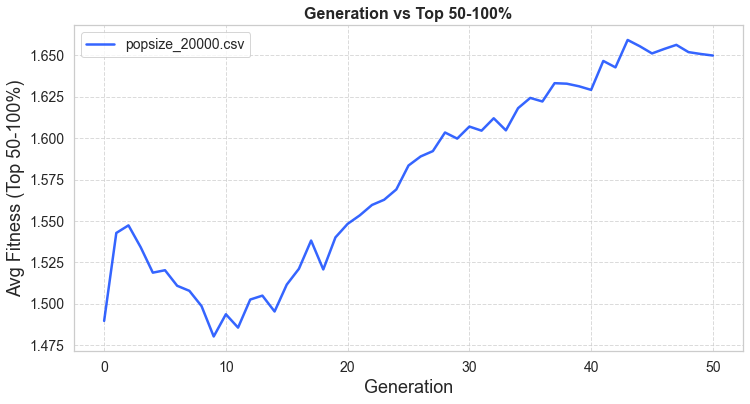

In [ ]:
import time

file_list = [r'popsize_20000.csv']
start = time.time()
analysis = GGMDAnalysis(file_list)
analysis.plot_percentile_fitness()
# avg_fitness = analysis.calculate_avg_fitness()
# print('Done: avg_fitness')
# t1 = time.time()
# print(t1 - start)
# max_fitness = analysis.calculate_max_fitness()
# print('Done: max_fitness')
# t2 = time.time()
# print(t2 - t1)
# percentile_fitness = analysis.calculate_percentile_fitness()
# print('Done: percentile_fitness')
# t3 = time.time()
# print(t3 - t2)
# diversity = analysis.calculate_avg_diversity()
# end = time.time()
# print(f"Time taken: {end - start:.2f} seconds")


In [ ]:
print(percentile_fitness)


    Generation   Fitness
0            0  2.517242
1            1  2.758390
2            2  2.848117
3            3  2.887627
4            4  2.883720
5            5  2.894323
6            6  2.904012
7            7  2.905150
8            8  2.893060
9            9  2.881137
10          10  2.871995
11          11  2.864874
12          12  2.854136
13          13  2.838317
14          14  2.845352
15          15  2.843854
16          16  2.835730
17          17  2.837065
18          18  2.828556
19          19  2.825663
20          20  2.828702
21          21  2.830207
22          22  2.825287
23          23  2.821254
24          24  2.812016
25          25  2.830277
26          26  2.815619
27          27  2.828153
28          28  2.837310
29          29  2.828102
30          30  2.818529
31          31  2.830224
32          32  2.828294
33          33  2.823046
34          34  2.832324
35          35  2.833840
36          36  2.827560
37          37  2.830159
38          38  2.829203


None


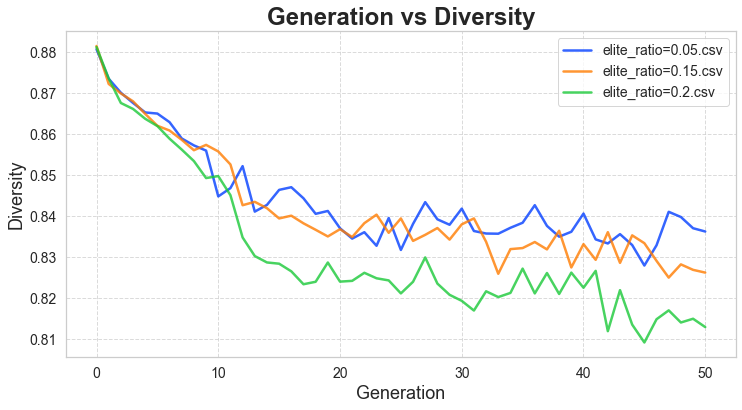

In [35]:
paths = [
    r"elite_ratio=0.05.csv",
    r"elite_ratio=0.15.csv",
    r"elite_ratio=0.2.csv",
    #r"elite_ratio=0.25.csv"
]
analysis = GGMDAnalysis(paths)
diversity = analysis.plot_avg_diversity()

Displaying top 2 molecules for File 0:


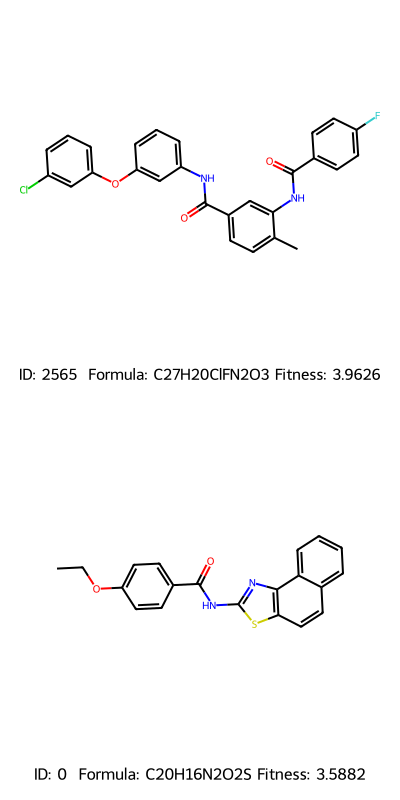

Displaying top 2 molecules for File 1:


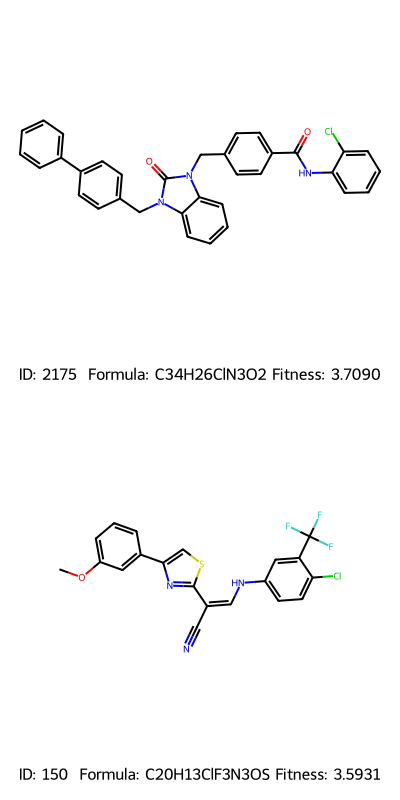

In [36]:
# Example usage
file_list = [r'Data 1.csv',
            r'Data 2.csv']
#file_list = ['result_670.csv', 'result_517.csv']
analysis = GGMDAnalysis(file_list)
#analysis.plot_avg_diversity(line_plot=True, regression=True, std=False, spline_smoothing=False, scatter=False)
analysis.display_top_n_molecules(2, shape=(2, 1))

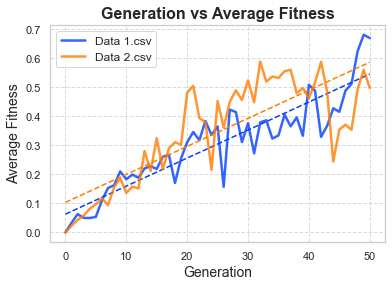

In [20]:
analysis.plot_avg_fitness(line_plot=True, regression=True, std=False, spline_smoothing=False, scatter=False, legend=True)

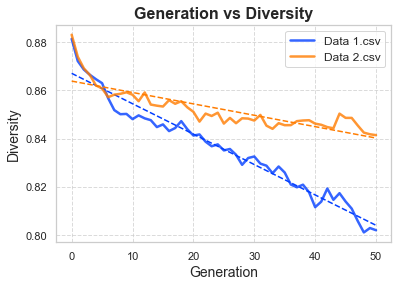

In [21]:
analysis.plot_avg_diversity(line_plot=True, regression=True, std=False, spline_smoothing=False, scatter=False)

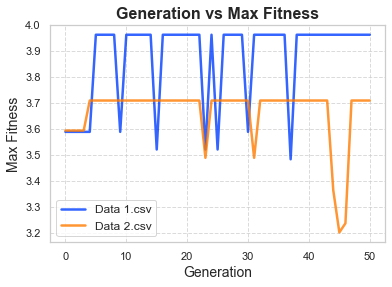

In [22]:
analysis.plot_max_fitness(line_plot=True, regression=False, std=False, spline_smoothing=False, scatter=False)

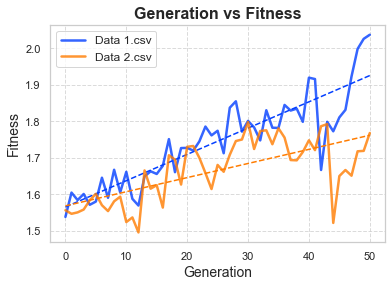

In [14]:
analysis.plot_percentile_fitness(50, 100, line_plot=True, regression=True, std=False, spline_smoothing=False, scatter=False)